In [1]:
import torch
import torchvision
import torch.utils.data as Data
import torch.optim as optim
import random
import numpy as np

from torch import nn
from matplotlib import pyplot as plt
from typing import Tuple


def train_epoch(data_loader: Data.DataLoader, net: nn.Module,
                loss_func, optimizer: torch.optim.Optimizer,
                device='cpu'):
    """
    训练迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param optimizer:   优化器
    :param device:      设备
    :return:    loss, acc
    """
    net.train()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    for batch_num, (x, y_true) in enumerate(data_loader):

        # 将数据放入指定的设备
        x = x.to(device).float()
        y_true = y_true.to(device).long()

        # 计算损失
        y_hat: torch.Tensor = net(x)
        loss = loss_func(y_hat, y_true)

        # 取概率最大的类别索引
        y_true: torch.Tensor = y_true.view(-1)
        y_hat = y_hat.argmax(dim=1)

        # 反向传播
        optimizer.zero_grad() #清空梯度
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (y_true == y_hat).float().sum().item()
        sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def test_epoch(data_loader: Data.DataLoader,
               net: nn.Module, loss_func, device='cpu'):
    """
    测试函数迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param device:      设备
    :return:    loss, acc
    """
    net.eval()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    with torch.no_grad():

        for batch_num, (x, y_true) in enumerate(data_loader):

            # 将数据放入指定的设备
            x = x.to(device).float()
            y_true = y_true.to(device).long()

            # 计算损失
            y_hat: torch.Tensor = net(x)
            loss = loss_func(y_hat, y_true)

            # 取概率最大的类别索引
            y_true: torch.Tensor = y_true.view(-1)
            y_hat = y_hat.argmax(dim=1)

            total_loss += loss.item()
            correct += (y_true == y_hat).float().sum().item()
            sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def plot_loss_accuracy(train_loss_list, train_acc_list,
                       test_loss_list, test_acc_list, info=''):
    """
    绘制 训练集和测试集正确率、损失值 的图形
    """
    x = np.linspace(0, len(train_loss_list), len(train_loss_list))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 6)
    if info:
        info = info + ' '

    ax1.plot(x, train_loss_list, 'b-', label="train_loss", lw=1)
    ax1.plot(x, test_loss_list, 'r-', label="test_loss", lw=1)
    ax1.set_title(info + 'Loss')
    ax1.legend(loc='best', frameon=False)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss")

    ax2.plot(x, train_acc_list, 'b-', label="train_accuracy", lw=1)
    ax2.plot(x, test_acc_list, 'r-', label="test_accuracy", lw=1)
    ax2.set_title(info + 'Accuracy')
    ax2.legend(loc='best', frameon=False)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("Accuracy")

    plt.show()


def plot_by_dict(metrics: dict, shape: Tuple[int, int]):
    """
    绘制图形 {指标: {参数值名1: [], 参数值名2: []}}
    """
    fig, axes = plt.subplots(shape[0], shape[1])
    axes = list(np.array(axes).ravel())
    fig.set_size_inches(10*shape[0], 6*shape[1])

    colors = ['b', 'r', 'y', 'c', 'k', 'g', 'w', 'm']
    for ax_no, title in enumerate(metrics.keys()):
        ax = axes[ax_no]
        for i, (key, values) in enumerate(metrics.get(title, {}).items()):
            x = np.linspace(0, len(values), len(values))
            ax.plot(x, values, colors[i], label=key, lw=1)
            ax.set_title(title)
            ax.legend(loc='best', frameon=False)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title.lower().split(' ')[-1])

    plt.show()

[HAMI-core Msg(17068:139786905402240:libvgpu.c:836)]: Initializing.....


#### 手动生成二分类任务的数据集
+ 共生成两个数据集。
+ 两个数据集的大小均为10000且训练集大小为7000，测试集大小为3000。
+ 两个数据集的样本特征`x的维度均为200`，且`分别服从均值互为相反数且方差相同的正态分布`。
+ 两个数据集的样本`标签分别为0和1`。

In [3]:
torch.random.manual_seed(1)

p = 200
mu = 5
std = 0.1
train_size = 7000
test_size = 3000

x_train = torch.vstack([
    torch.normal(mean=mu, std=std, size=(train_size, p)),
    torch.normal(mean=-mu, std=std, size=(train_size, p))
])
y_train = torch.hstack([
    torch.ones(train_size, dtype=torch.float),
    torch.zeros(train_size, dtype=torch.float),
])
x_test = torch.vstack([
    torch.normal(mean=mu, std=std, size=(test_size, p)),
    torch.normal(mean=-mu, std=std, size=(test_size, p))
])
y_test = torch.hstack([
    torch.ones(test_size, dtype=torch.float),
    torch.zeros(test_size, dtype=torch.float),
])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# 构造数据集
train_set = Data.TensorDataset(x_train, y_train)
test_set = Data.TensorDataset(x_test, y_test)

torch.Size([14000, 200]) torch.Size([14000])
torch.Size([6000, 200]) torch.Size([6000])


#### 手动实现前馈神经网络
分析实验结果并绘制训练集和测试集的loss曲线

[HAMI-core Warn(17068:139786905402240:utils.c:183)]: get default cuda from (null)
[HAMI-core Msg(17068:139786905402240:libvgpu.c:855)]: Initialized


epoch 1, train_loss 0.018377, test_loss 0.000361, train_acc 0.990857, test_acc 1.000000
epoch 2, train_loss 0.000241, test_loss 0.000165, train_acc 1.000000, test_acc 1.000000
epoch 3, train_loss 0.000131, test_loss 0.000105, train_acc 1.000000, test_acc 1.000000
epoch 4, train_loss 0.000089, test_loss 0.000076, train_acc 1.000000, test_acc 1.000000
epoch 5, train_loss 0.000067, test_loss 0.000059, train_acc 1.000000, test_acc 1.000000
epoch 6, train_loss 0.000053, test_loss 0.000048, train_acc 1.000000, test_acc 1.000000
epoch 7, train_loss 0.000044, test_loss 0.000040, train_acc 1.000000, test_acc 1.000000
epoch 8, train_loss 0.000038, test_loss 0.000035, train_acc 1.000000, test_acc 1.000000
epoch 9, train_loss 0.000033, test_loss 0.000031, train_acc 1.000000, test_acc 1.000000
epoch 10, train_loss 0.000029, test_loss 0.000027, train_acc 1.000000, test_acc 1.000000
epoch 11, train_loss 0.000026, test_loss 0.000024, train_acc 1.000000, test_acc 1.000000
epoch 12, train_loss 0.000023,

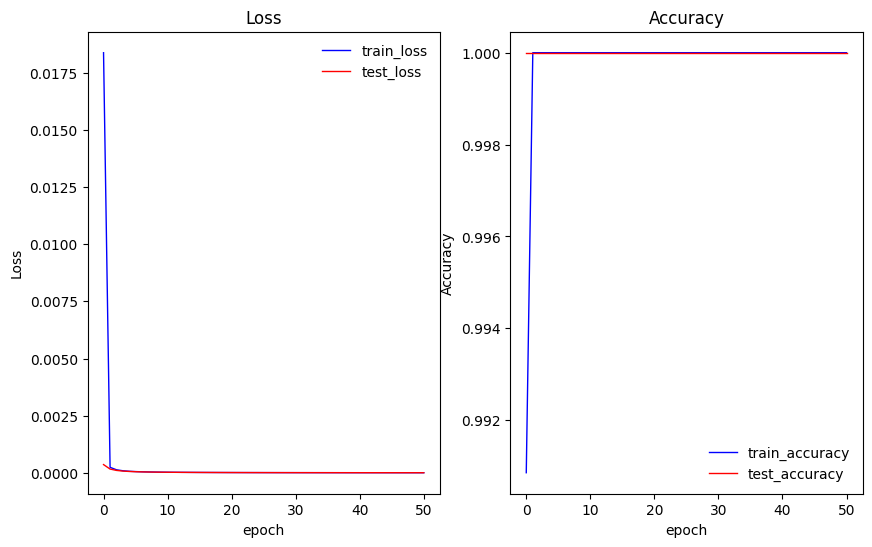

In [4]:
def data_iter(x: torch.Tensor, y: torch.Tensor, batch_size: int=8,
              seed=1, shuffle=True):
    """ 数据集生成器 """

    num_samples = x.shape[0]
    indices = list(range(num_samples))
    if shuffle:
        random.seed(seed)
        random.shuffle(indices)

    # 构造小批次数据集
    for i in range(0, num_samples, batch_size):

        # 选取的该批次内的行索引
        j = torch.tensor(indices[i: min(i+batch_size, num_samples)])

        yield x.index_select(dim=0, index=j), y.index_select(0, j)


def sgd(lr, *params):
    """
    优化器-梯度下降
    :param lr:          学习率
    :param params:      参数列表
    :return:
    """
    for param in params:
        # 注意这里更改param时用的param.data
        param.data -= lr * param.grad

def sigmoid(x: torch.Tensor) -> torch.Tensor:
    """
    激活函数-逻辑斯蒂回归
    x: [batch_size, ]
    :return [batch_size, 1]
    """
    return 1 / (1 + torch.exp(-x))


def binary_cross_entropy(y_hat: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    损失函数-二元交叉熵
    :param y_hat(one_hot):   预测值 (batch_size, 1)
    :param y_true:           真值  (batch_size)
    :return:
    """
    y_hat = y_hat.view(y_true.size())
    l =  y_true * torch.log(y_hat) + (1-y_true) * torch.log(1 - y_hat)
    return - l.sum()/y_true.shape[0]


def relu(x: torch.Tensor):
    """
    线性单元
    :param x:
    :param gamma:
    :return:
    """
    x = torch.where(x >= 0, x, torch.zeros(x.size()))
    return x

def neural_net(x: torch.Tensor, *params) -> torch.Tensor:
    """
    前馈神经网络
    :param x:       特征
    :param params:  模型参数
    :return:
    """
    w1, b1, w2, b2 = params
    # hidden = tanh(torch.mm(x, w1) + b1)
    # hidden = leak_relu(torch.mm(x, w1) + b1)
    hidden = relu(torch.matmul(x, w1) + b1)
    return sigmoid(torch.matmul(hidden, w2) + b2)


def evaluate_loss_acc(data_iter, net, loss_fn, *params):
    """
    返回测试集的loss
    :return:
    """
    test_l_sum, acc_sum, num_batch, n = 0.0, 0.0, 0, 0
    for x, y_true in data_iter:

        y_hat = net(x, *params)
        y_hat: torch.Tensor = y_hat.view(y_true.size())

        test_l_sum += loss_fn(y_hat, y_true)

        y_hat = torch.where(y_hat > 0.5, 1, 0)
        acc_sum += (y_hat == y_true).float().sum().item()

        num_batch += 1
        n += y_true.shape[0]

    return test_l_sum/num_batch, acc_sum/n


# 参数配置
num_inputs = x_train.shape[1]
num_hiddens = 128
num_outputs = 1

batch_size = 256
num_epochs = 50
lr = 0.1
net = neural_net
loss = binary_cross_entropy

# 模型训练 w = [w_0, ..., w_n]
w1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)),
                  dtype=torch.float32)
b1 = torch.zeros(num_hiddens, dtype=torch.float32)
w2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)),
                  dtype=torch.float32)
b2 = torch.zeros(num_outputs, dtype=torch.float32)

params = (w1, b1, w2, b2)
for param in params:
    param.requires_grad_(requires_grad=True)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(num_epochs):

    # 读取数据集
    iter_train = data_iter(x_train, y_train, batch_size=batch_size)
    iter_test = data_iter(x_test, y_test, batch_size=batch_size)

    # 一批次的训练数据
    train_l_sum, train_acc_sum, num_batch, n = 0.0, 0.0, 0, 0
    for X, y_true in iter_train:

        # 模型预测值
        y_hat:torch.Tensor = net(X, *params)

        # 损失值
        l = loss(y_hat, y_true)

        # 反向传播
        l.backward()

        # 随机梯度下降
        sgd(lr, *params)

        # 梯度置零
        for param in params:
            param.grad.data.zero_()

        y_hat = y_hat.view(y_true.size())
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        train_acc_sum += (y_hat == y_true).float().sum().item()
        train_l_sum += l

        num_batch += 1
        n += y_true.shape[0]

    train_l = train_l_sum / num_batch
    train_acc = train_acc_sum / n
    test_l, test_acc = evaluate_loss_acc(iter_test, net, loss, *params)

    train_loss.append(train_l.detach().numpy())
    test_loss.append(test_l.detach().numpy())
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_l, test_l, train_acc_sum/n, test_acc))


plot_loss_accuracy(train_loss, train_accuracy, test_loss, test_accuracy)

#### torch.nn实现前馈神经网络
分析实验结果并绘制训练集和测试集的loss曲线

In [5]:
class TorchNeuron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 activation=nn.ReLU, num_layers=1, drop_out_rate=0):
        super(TorchNeuron, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.activation = activation
        self.drop_out_rate = drop_out_rate

        self.linear = nn.Sequential(*self.create_linear_layers())

        for param in self.linear.parameters():
            nn.init.normal_(param, std=0.01)

    def create_linear_layers(self) -> Tuple[nn.Module]:
        """
        创建层
        :return:
        """
        modules = [
            nn.Linear(self.input_size, self.hidden_size),
            self.activation(),
            nn.Dropout(self.drop_out_rate),
        ]
        for i in range(self.num_layers - 1):
            modules.append(nn.Linear(self.hidden_size, self.hidden_size))
            modules.append(self.activation())
            modules.append(nn.Dropout(self.drop_out_rate))
        modules.append(nn.Linear(self.hidden_size, self.output_size))
        return tuple(modules)

    def forward(self, x):
        return self.linear(x)

In [6]:
# 参数配置
device = 'cpu'
input_size = x_train.shape[1]
hidden_size = 256
output_size = 2

batch_size = 256
num_epochs = 50
lr = 0.1

net = TorchNeuron(input_size, hidden_size, output_size)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

# 构造数据集
dataset_train = Data.TensorDataset(x_train, y_train)
dataset_test = Data.TensorDataset(x_test, y_test)

# 读取数据集
iter_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
iter_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

##### 采用10折交叉验证评估实验结果
要求除了最终结果外还需以表格的形式展示每折的实验结果

In [22]:
import torch
from sklearn.model_selection import KFold


def train(train_data_loader, test_data_loader):

    net = TorchNeuron(input_size, hidden_size, output_size, drop_out_rate=0.3)
    print(net)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=0.0)

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(num_epochs):

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('lr=%s epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (lr, epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    return train_loss_list, train_acc_list, test_loss_list, test_acc_list

# 参数配置
device = 'cpu'
input_size = x_train.shape[1]
hidden_size = 256
output_size = 2

batch_size = 256
num_epochs = 10
lr = 0.1

X = torch.cat((x_train, x_test))
y = torch.cat((y_train, y_test))

indices = np.arange(0, X.shape[0])
kf = KFold(n_splits=10)

kf_train_loss, kf_train_acc, kf_test_loss, kf_test_acc = [], [], [], []
for train_index, test_index in kf.split(indices):
    train_index = torch.LongTensor(train_index)
    test_index = torch.LongTensor(test_index)

    train_x = torch.index_select(X, dim=0, index=train_index)
    train_y = torch.index_select(y, dim=0, index=train_index)
    test_x = torch.index_select(X, dim=0, index=test_index)
    test_y = torch.index_select(y, dim=0, index=test_index)

    train_set = Data.TensorDataset(train_x, train_y)
    test_set = Data.TensorDataset(test_x, test_y)

    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # 训练
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = train(train_data_loader, test_data_loader)

    kf_train_loss.append(train_loss_list)
    kf_train_acc.append(train_acc_list)
    kf_test_loss.append(test_loss_list)
    kf_test_acc.append(test_acc_list)

TorchNeuron(
  (linear): Sequential(
    (0): Linear(in_features=200, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)
lr=0.1 epoch 1, train_loss 0.009769, test_loss 0.000130, train_acc 0.994444, test_acc 1.000000
lr=0.1 epoch 2, train_loss 0.000102, test_loss 0.000062, train_acc 1.000000, test_acc 1.000000
lr=0.1 epoch 3, train_loss 0.000066, test_loss 0.000041, train_acc 1.000000, test_acc 1.000000
lr=0.1 epoch 4, train_loss 0.000052, test_loss 0.000031, train_acc 1.000000, test_acc 1.000000
lr=0.1 epoch 5, train_loss 0.000042, test_loss 0.000025, train_acc 1.000000, test_acc 1.000000
lr=0.1 epoch 6, train_loss 0.000036, test_loss 0.000022, train_acc 1.000000, test_acc 1.000000
lr=0.1 epoch 7, train_loss 0.000033, test_loss 0.000020, train_acc 1.000000, test_acc 1.000000
lr=0.1 epoch 8, train_loss 0.000031, test_loss 0.000018, train_acc 1.000000, test_acc 1.000000
lr=0.1 epoch 9, trai

In [23]:
kf_train_loss_np = np.array(kf_train_loss)
kf_train_acc_np = np.array(kf_train_acc)

kf_test_loss_np = np.array(kf_test_loss)
kf_test_acc_np = np.array(kf_test_acc)

print(kf_test_loss_np.min(axis=1))
print(kf_test_loss_np.mean(axis=1))

print(kf_test_acc_np.max(axis=1))
print(kf_test_acc_np.mean(axis=1))

[1.55238345e-05 1.34269281e-05 1.41567948e-05 1.38647451e-05
 1.70274982e-05 1.67884380e-05 1.78620262e-05 1.52344270e-05
 1.20956392e-05 1.44826975e-05]
[3.80892912e-05 2.95931347e-05 3.02551834e-05 3.00995494e-05
 3.87915284e-05 3.66381004e-05 3.89902085e-05 3.42971369e-05
 2.55111829e-05 3.24274791e-05]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
